# Periodic Driving
In this example we want to efficiently implement a Spin Echo pulse using periodic driving by making use of the concatenation property of filter functions. We assume a control Hamiltonian of the form

$$
    {H}_c = \frac{\omega_0}{2}\sigma_z + A\sin(\omega_\mathrm{d}t + \phi)\sigma_x
$$

and compute the filter function for a single period of the drive:

In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
import qutip as qt

import filter_functions as ff

In [2]:
# use widget for interactive mode
%matplotlib inline

In [3]:
# We calculate with hbar == 1
Delta = 0.0   # set detuning to zero
omega_d = 20e9*2*np.pi
omega_0 = omega_d + Delta
# Phase shift; phi = 0 gives us a rotation about Y, phi = pi/2 about X
phi = np.pi/2
# Rabi frequency
Omega_R = 1e6*2*np.pi
A = np.sqrt(Omega_R**2 - Delta**2)
T = 2*np.pi/omega_d

t = np.linspace(0, T, 21)
dt = np.diff(t)
# Paulis
X, Y, Z = ff.util.paulis[1:]

H_c = [[Z, [omega_0/2]*len(dt), 'Z'],
       [X, A*np.sin(omega_d*t[1:] + phi), 'X']]
H_n = [[Z, np.ones_like(dt), 'Z'],
       [X, np.ones_like(dt), 'X']]

# Track the performance of the individual steps
tic = []
toc = []

tic.append(time.perf_counter())
X_ATOMIC = ff.PulseSequence(H_c, H_n, dt)
toc.append(time.perf_counter())

# We have to set the frequencies now, and since we plan to make a much longer
# sequence than just a single period, we choose a much lower infrared cutoff 
# than we would for the single period.
omega = np.geomspace(1e-8*omega_0, 1e2*omega_0, 500)

# Cache the filter function for a single period of the drive to be able to
# reuse it later.
tic.append(time.perf_counter())
X_ATOMIC.cache_filter_function(omega)
toc.append(time.perf_counter())

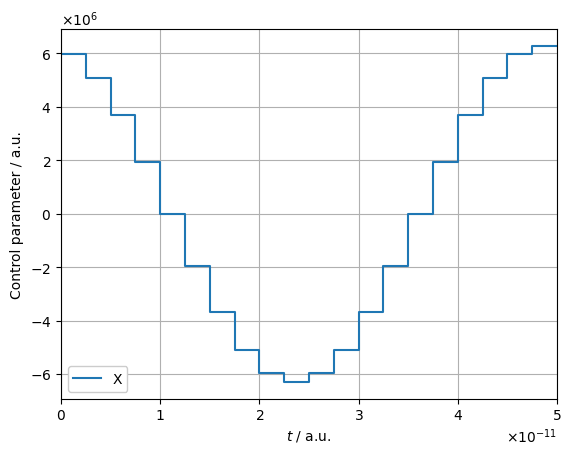

In [4]:
# Plot the pulse train for the drive only
from filter_functions import plotting

_ = plotting.plot_pulse_train(X_ATOMIC, c_oper_identifiers=['X'])

## Concatenating filter functions
In order to achieve a rotation by $\pi$ about the $x$-axis, we need to pulse for $t = \frac{\omega_\mathrm{d}}{2\Omega_R }T$, that is, repeat `X_ATOMIC` 10000 times:

In [5]:
from itertools import repeat

tic.append(time.perf_counter())
NOT_PERIODIC = ff.concatenate_periodic(X_ATOMIC, 10000)
toc.append(time.perf_counter())

tic.append(time.perf_counter())
NOT_STANDARD = ff.concatenate(repeat(X_ATOMIC, 10000))
toc.append(time.perf_counter())

We can check if the concatenated pulse actually does what we intended it to do by computing the overlap with the target propagator $U_t = \sigma_x$ via the Hilbert-Schmidt inner product,

$$
    \frac{1}{d}\left|\langle Q, U_t\rangle_\mathrm{HS}\right| = \frac{1}{d}\left|\mathrm{tr}\!\left(Q^\dagger U_t\right)\right|,
$$

where we take the absolute value since a global phase is of no interest.

Trace fidelity:  0.98766778476173


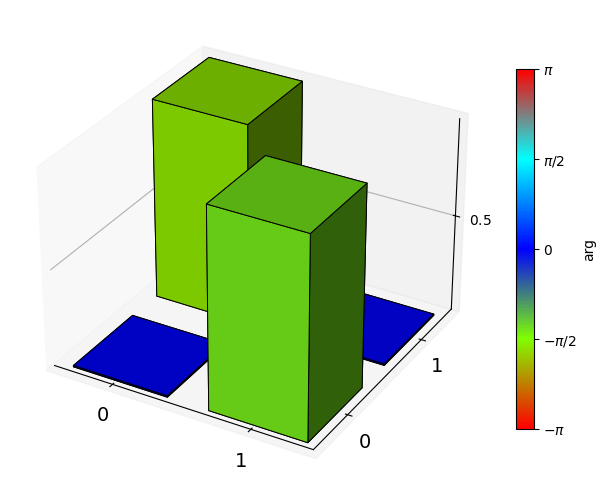

In [6]:
# Overlap between the target and actual propagators
print('Trace fidelity: ', abs(ff.util.dot_HS(NOT_PERIODIC.total_propagator, qt.sigmax()))/2)
# Plot the total propagator of NOT
_ = qt.matrix_histogram(NOT_PERIODIC.total_propagator, bar_style='abs', color_style='phase')

Finally, we sandwich the $\pi$-pulse between two periods of free evolution to get the filter function for the SE:

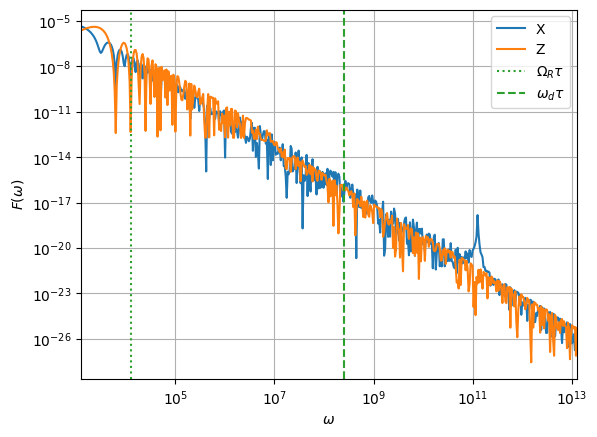

In [7]:
# Since we do not apply any control, we can just use one very long time step
dt = [1e-3]  # 1 ms
H_c = [[X, [0], 'X']]
H_n = [[Z, np.ones_like(dt), 'Z'],
       [X, np.ones_like(dt), 'X']]

WAIT = ff.PulseSequence(H_c, H_n, dt)

# Get the total pulse. We can also use the @ operator for simple concatenation
tic.append(time.perf_counter())
ECHO = ff.concatenate((WAIT, NOT_PERIODIC, WAIT))
toc.append(time.perf_counter())

# Plot 
fig, ax, _ = plotting.plot_filter_function(ECHO, omega, yscale='log')
ax.axvline(Omega_R*ECHO.tau, label=r'$\Omega_R\tau$', ls=':',
           color='tab:green')
ax.axvline(omega_0*ECHO.tau, label=r'$\omega_d\tau$', ls='--',
           color='tab:green')
ax.legend()

As expected, the $\sigma_z$-filter function shows DC noise suppression. Notably, the filter function for $\sigma_x$ has a dip at the Rabi frequency $\Omega_\mathrm{R}$ and a sharp peak at the drive/resonance frequency $\omega_\mathrm{d}$.

## Comparison to brute-force method
To get an idea of the performance gain when using concatenation over brute force calculating the whole filter function in one go, we can run the latter calculation (takes about four minutes on relatively recent hardware):

In [8]:
t = np.linspace(0, T*10000, len(X_ATOMIC.dt)*10000+1)
dt = np.diff(t)
H_c = [[Z, [omega_0/2]*len(dt), 'Z'],
       [X, A*np.sin(omega_d*t[1:] + phi), 'X']]
H_n = [[Z, np.ones_like(dt), 'Z'],
       [X, np.ones_like(dt), 'X']]

tic.append(time.perf_counter())
NOT_FULL = ff.PulseSequence(H_c, H_n, dt)
# Suppress the calculation of the filter function during concatenation since we
# want to do it on the full pulse for comparison
ECHO_FULL = ff.concatenate((WAIT, NOT_FULL, WAIT), calc_filter_function=False)

F = ECHO_FULL.get_filter_function(omega, show_progressbar=True)
toc.append(time.perf_counter())

Calculating control matrix:   0%|          | 0/200002 [00:00<?, ?it/s]

In [9]:
tictoc = np.array(toc) - np.array(tic)

labels = ['ATOMIC initialization\t\t', 'ATOMIC filter function\t\t',
          'NOT concatenation (periodic)\t', 'NOT concatenation (standard)\t',
          'ECHO concatenation\t\t']
print('===========================================')
for l, tito in zip(labels, tictoc):
    print(l, ':', '{:.4f}'.format(tito), 's')
print('-------------------------------------------')
print('Total (periodic)\t\t', ':',
      '{:.4f}'.format(tictoc[np.array([0, 1, 2, 4])].sum()), 's')
print('Total (standard)\t\t', ':',
      '{:.4f}'.format(tictoc[np.array([0, 1, 3, 4])].sum()), 's')
print('===========================================')
print('Total (brute force)\t\t', ':', '{:.2f}'.format(tictoc[-1]), 's')
print('===========================================')

ATOMIC initialization		 : 0.0009 s
ATOMIC filter function		 : 0.0157 s
NOT concatenation (periodic)	 : 0.0286 s
NOT concatenation (standard)	 : 0.9008 s
ECHO concatenation		 : 0.0093 s
-------------------------------------------
Total (periodic)		 : 0.0546 s
Total (standard)		 : 0.9267 s
Total (brute force)		 : 38.38 s


As we can see, there is tremendous gain in performance to be had when concatenating the pulses. Realistically, this would be even more drastic as the sampling rate for a single period is too small to give a very percise result (as can be seen from the overlap with the target $X$-gate being rather small at 98.8%).

## Comparing the weak and strong driving regimes
Let us now compare the susceptibility of a Rabi pulse in the weak driving regime where $A\ll\omega_\mathrm{d}$, to that of one in the strong driving regime where $A\sim\omega_\mathrm{d}$. Here, one cannot apply the rotating wave approximation (RWA) anymore without making large errors.

Below, we will use the analytical solution for a flux qubit biased at its symmetry point from [Deng et al. (2015)](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.115.133601) with $A=\omega_\mathrm{d}/4$ on the one hand, and the weak driving results shown above on the other, to drive the qubit for 20 identity rotations in total. This corresponds to a total time of $\tau_\mathrm{strong}\approx 4\mathrm{ns}$ ($\tau_\mathrm{weak}\approx 20\mathrm{μs}$) for the first (last) case.

Having already calculated a $\pi$ rotation in the weak driving limit, we just concatenate 40 copies of the result to obtain the total pulse.

In [10]:
ID20_WEAK = ff.concatenate_periodic(NOT_PERIODIC, 40)

We use a trivial pulse shape envelope for the strong driving pulse here but give the general expressions to experiment with.

In [11]:
import warnings
from scipy.special import j0, j1  # Bessel functions


def get_envelope(A_m, t_r, t_f, t):
    t_p = t[-1] - t_f - t_r
    A = np.full_like(t, A_m)
    A[t <= t_r] = A_m/2*(1 - np.cos(np.pi*t[t <= t_r]/t_r))
    A[t > t_p + t_r] = A_m/2*(1 + np.cos(np.pi*(t[t > t_p + t_r] - t_p - t_r)/t_f))
    return A


A_m = omega_d / 4

# https://journals.aps.org/pra/pdf/10.1103/PhysRevA.94.032323
Omega_R_STRONG = np.sqrt((omega_d - omega_0*j0(2*A_m/omega_d))**2
                         + omega_0**2*j1(2*A_m/omega_d)**2)

# Disable rise and fall times for simplicity
t_r = 0/omega_d
t_p = 2*np.pi/Omega_R_STRONG/2
t_f = 0/omega_d

tau = t_r + t_p + t_f
t = np.linspace(0, tau, 500)
dt = np.diff(t)

with warnings.catch_warnings():
    # Zero divison warning b/c rise and fall times are zero
    warnings.simplefilter('ignore')
    A = get_envelope(A_m, t_r, t_f, t)

H_c = [[Z, [omega_0/2]*len(dt), 'Z'],
       [X, A[1:]*np.sin(omega_d*t[1:] + phi), 'X']]
H_n = [[Z, np.ones_like(dt), 'Z'],
       [X, np.ones_like(dt), 'X']]

omega_STRONG = np.geomspace(1e7, 1e13, 1004)
NOT_STRONG = ff.PulseSequence(H_c, H_n, dt)
NOT_STRONG.cache_control_matrix(omega_STRONG)
ID20_STRONG = ff.concatenate_periodic(NOT_STRONG, 40)

Inspecting the systematic (trace) fidelity of the $\pi$ pulse, we can already see one of the difficulties arising for strong driving: timing precision. Whereas in the case of weak driving, the trace fidelity was relatively small due to numerical imprecision (because we wanted to keep the computation time in check), here the accuracy is limited by the pulse itself.

Trace fidelity:  0.997876097258005


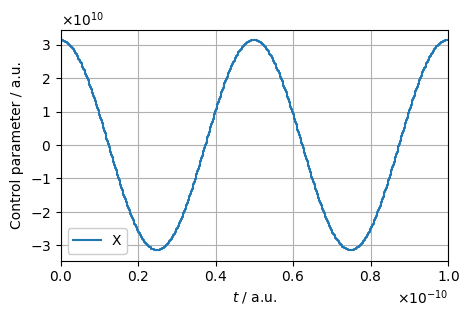

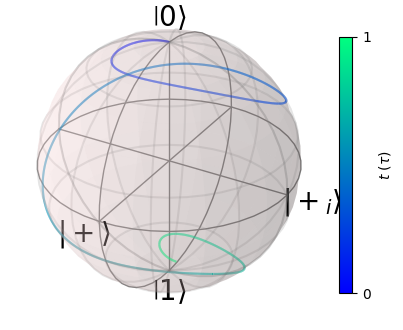

In [12]:
print('Trace fidelity: ',
      abs(ff.util.dot_HS(NOT_STRONG.total_propagator, ff.util.paulis[1])) / 2)
plotting.plot_pulse_train(NOT_STRONG, c_oper_identifiers=['X'],
                          figsize=(5, 3))
plotting.plot_bloch_vector_evolution(NOT_STRONG, add_cbar=True, figsize=(5, 5))

Let us now compare the filter functions of the continuous driving pulses.

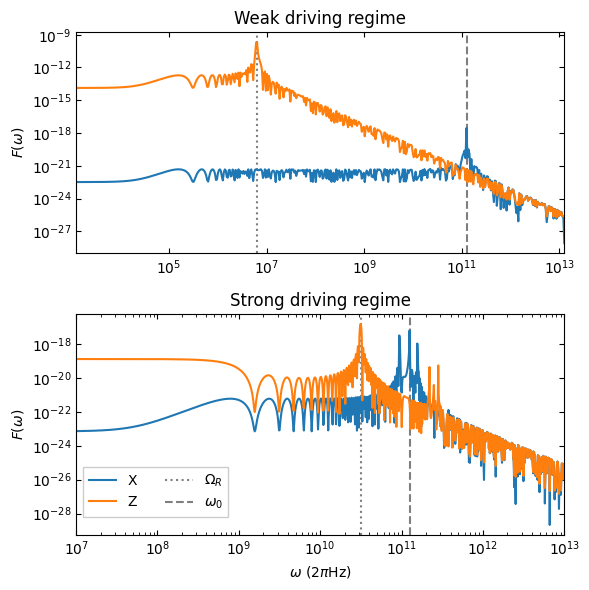

In [13]:
fig, axes = plt.subplots(2, 1, figsize=(6, 6))

_ = plotting.plot_filter_function(
    ID20_WEAK, omega_in_units_of_tau=False,
    xscale='log', yscale='log',
    fig=fig, axes=axes[0]
)
_ = plotting.plot_filter_function(
    ID20_STRONG, omega_in_units_of_tau=False,
    xscale='log', yscale='log',
    fig=fig, axes=axes[1]
)

# Some cosmetics
for ax, reg, O in zip(axes, ('Weak', 'Strong'), (Omega_R, Omega_R_STRONG)):
    ax.axvline(O, ls=':', color='tab:grey',
               label=r'$\Omega_R$', zorder=0)
    ax.axvline(omega_d, ls='--', color='tab:grey',
               label=r'$\omega_0$', zorder=0)
    ax.tick_params(direction='in', which='both')
    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')
    ax.grid(False)
    ax.set_xlabel(r'$\omega$ ($2\pi$Hz)')
    ax.set_xlabel(r'$\omega$ ($2\pi$Hz)')
    ax.set_title(reg + ' driving regime')
    
# Undo some things that plotting.plot_filter_function does
axes[0].get_legend().set_visible(False)
axes[0].set_xlabel('')
# Redraw legend
legend = axes[1].legend(loc='lower left', ncol=2, frameon=True, framealpha=1,
                        bbox_to_anchor=(0, 0.05), fancybox=False)
fig.tight_layout()

A few things stand out here. First, notice that the DC level of the Z filter function $F_{zz}(\omega)$ is five orders of magnitude smaller for strong driving, whereas that of $F_{xx}(\omega)$ is comparable. Second, while the weak driving pulse cancels slow noise on both axes (the levelling out of the filter functions towards small frequencies is due to small numerical precision), the strong driving pulse does not (the levelling out is a real feature here). This can be understood by the fact that in the first case, the Bloch vector explores a large portion of the surface of the Bloch sphere during the pulse, thereby averaging over slow noise efficiently, whereas in the latter case this is not so. Lastly, we can see several resonances in the susceptibility. Both pulses expectedly showcase resonances at the driving frequency as well as their respective Rabi frequencies. However, the strong driving pulse also shows peaks at $\omega=\omega_0\pm\Omega_R$ in $F_{xx}(\omega)$ as well as resonances in $F_{zz}(\omega)$ at higher frequencies, a result of the strong coupling.